# Dog breed classification

This project is about training and deploying a model which can classify a dog breed for a given image.
I use a dataset hosted by Udacity: [dogImages](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip). It consists of images of 133 (!) dog breeds.

This notebook is divided into sections:
* Dataset. I explain what the dataset is, show some sample images and statistics and discuss what can make this project difficult.
* Hyperparameter Tuning
* Model Profiling and Debugging
* Model Deploying

## Imports

In [2]:
!pip install smdebug --quiet
!pip install --upgrade bokeh==2.4.3 --quiet

In [23]:
import os

import sagemaker
import boto3
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import host_subplot
import seaborn as sns
from PIL import Image

from sagemaker.pytorch import PyTorch
from sagemaker.session import TrainingInput
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.debugger import (
    Rule,
    ProfilerRule,
    DebuggerHookConfig,
    TensorBoardOutputConfig,
    CollectionConfig,
    rule_configs,
)
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

import torchvision.transforms as transforms

In [4]:
sns.set_theme()

## Dataset

THe dataset contains .jpg images of dogs, which are classified into 133 different classes. Each class has its own subfolder and the data is already divided into train/, valid/ and test/ sets.

There are 6680 train images, 835 validation images and 836 test images.

In [8]:
# I comment this out because it enough to download it once
# Command to download and unzip data
# !wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip --no-check-certificate
# !unzip dogImages.zip

In [9]:
from pathlib import Path
images_base_path = Path("./dogImages/")

def count_class_size(folder: str):
    data_path = images_base_path / folder
    class_iterator = (path for path in data_path.iterdir() if path.is_dir())
    class_size_counter = {}
    for class_folder in class_iterator:
        n_images = len(list(class_folder.glob("*.jpg")))
        class_size_counter[class_folder.name] = n_images

    return class_size_counter

train_classes = count_class_size("train")
val_classes = count_class_size("valid")
test_classes = count_class_size("test")

print(f"Number of classes: {len(train_classes.keys())}")
assert len(train_classes.keys()) == len(val_classes.keys()) == len(test_classes.keys())

print(f"Number of train images: {sum(train_classes.values()):>10}")
print(f"Number of validation images: {sum(val_classes.values()):>4}")
print(f"Number of test images: {sum(test_classes.values()):>10}")

Number of classes: 133
Number of train images:       6680
Number of validation images:  835
Number of test images:        836


In [10]:
print(f"Average number of train images per class: {sum(train_classes.values()) / len(train_classes.keys()) :.0f}")

Average number of train images per class: 50


The classes don't have equal size. The biggest class has 77 training images, and the smallest 26 training images. On average there is training 50 images per class.

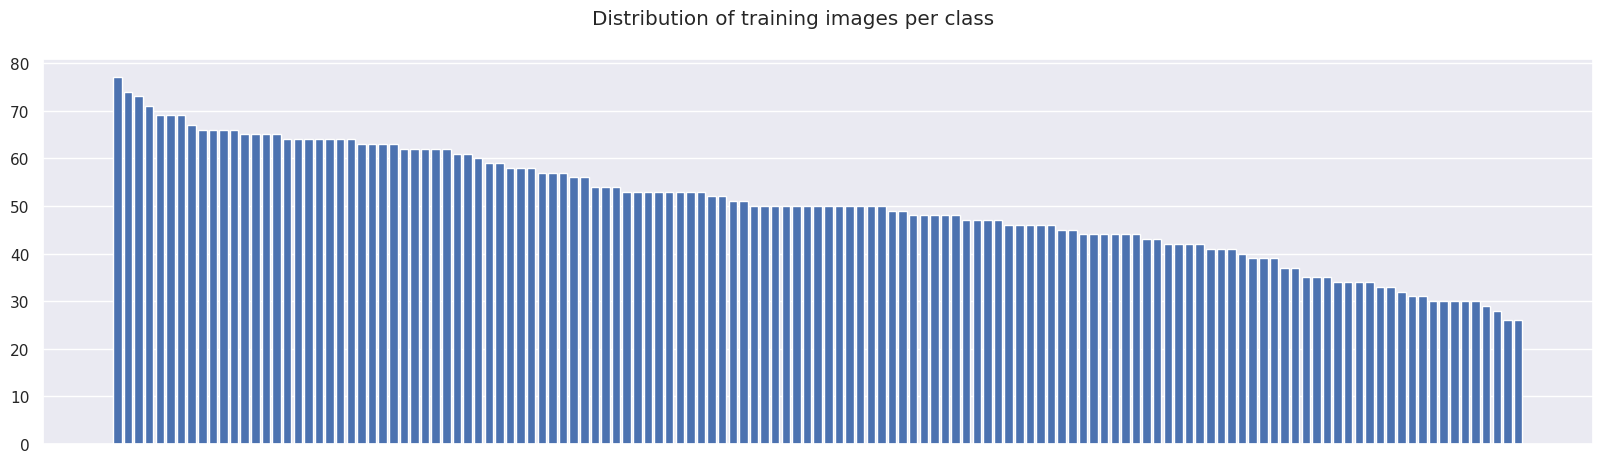

In [11]:
train_class_size_sorted = sorted(train_classes.values(), reverse=True)

fig, ax = plt.subplots(figsize=(20, 5))
ax.bar(range(len(train_class_size_sorted)), train_class_size_sorted)
ax.get_xaxis().set_visible(False)
fig.suptitle("Distribution of training images per class")
plt.show()

Few samples per each class might make this problem difficult to solve. Especially when paired with the fact, that some of the breeds are similar, and some dogs of the same breed look differently (they might have different color). Please, take a look at the images below. The model needs to classify all three images as the same class!

<table>
  <tr>
    <td align="center">
      <img src="images/Cavalier_king_charles_spaniel_03302.jpg" alt="Left Image"><br>
      <em>Blenheim (chestnut and white)</em>
    </td>
    <td align="center">
      <img src="images/Cavalier_king_charles_spaniel_03300.jpg" alt="Center"><br>
      <em>Tricolour (black/white/tan)</em>
    </td>
    <td align="center">
      <img src="images/Cavalier_king_charles_spaniel_03247.jpg" alt="Right Image"><br>
      <em>Black and tan</em>
    </td>
  </tr>
    <em>Fig: Cavalier King Charles Spaniel comes in a variety of colors. However, they are all beutiful!</em>
</table>

## Hyperparameter Tuning

I use the `hpo.py` script to perform hyperparameter tuning.

I decide to tune three parameters:
* learning rate
* weight decay
* batch size

I use [Adam optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) to train the model. It's an algorithm which adaptively adjust the momentum, so that it doesn't overshoot when it's close to a local minimum.
This means that there are not so many parameters to tune, because the algorithm itself adjust to the situation. 

The most important one is the `learning rate`, which defines the initial speed of training. The default value for Adam is $0.001$. I try a range of values from $0.001$ to $0.1$.
I decide not to tune $\beta_1$ and $\beta_2$. Their default values are considered to be good in most cases. I also think that tuning such parameters makes sense if one uses a lot of HPO trials.
In this case I run just 16 training jobs, to not exceed the budget.

However, I decide to tune `weight decay`, which is also called [$L2$ penalty](https://en.wikipedia.org/wiki/Regularization_(mathematics)). It helps in preventing overfitting. But because I train only one linear layer (the ResNet weights are frozen) I don't want this penalty to be too big, to not shrink my weights towards 0. That's why a try a range of values from $0$ to only $10^{-5}$.

The last parameter I tune is `batch size`. I try values $64$, $128$ and $256$. I don't want to use values smaller than $64$, because the usage of the GPU machine costs money and smaller batches would underutilize the GPU. I don't try larger values than 256 because I thought that it might not fit on the chepeast GPU machine I use here.

I train each model for $5$ epochs. The number of epochs could also be tuned. However, I don't want to let the model run for too long - again for money constaint.
I run 16 different training jobs, so that it has a chance to try different combinations of `learning rate`, `weight decay` and `batch size`. 
I train each model on `"ml.g4dn.xlarge"` machine, which I found to be the chepeast EC2 instance with GPU (see [pricing](https://aws.amazon.com/sagemaker-ai/pricing/)).
As I will see after the tuning job is completed, each individual job takes around 7 minutes.

In [50]:
hyperparameter_ranges = {
    "learning-rate": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([64, 128, 256]),
    "weight-decay": ContinuousParameter(0.0, 1e-5),
}

In [51]:
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [52]:
estimator = PyTorch(
    entry_point="hpo.py",
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    framework_version="1.13",
    py_version="py39",
    hyperparameters={
         "epochs": "5",
    }
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=16,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [48]:
sess = sagemaker.Session()
bucket_name = sess.default_bucket()

dataset_prefix = f"s3://{bucket_name}/datasets/dogImages"

In [54]:
tuner.fit(
    {
        "training": TrainingInput(f"{dataset_prefix}/train/", distribution="FullyReplicated"),
        "test": TrainingInput(f"{dataset_prefix}/valid/", distribution="FullyReplicated"),
    },
    wait=True
)

[04/10/25 11:12:38] INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=990626;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=762191;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#681\681]8;;\
                             instance_type, framework etc.                                                         

                    WARNING  No finished training job found associated with this estimator.       ]8;id=975430;file:///opt/conda/lib/python3.11/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=54163;file:///opt/conda/lib/python3.11/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    WARNING  No finished training job found associated with this estimator.       ]8;id=126043;file:///opt/conda/lib/python3.11/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=808884;file:///opt/conda/lib/python3.11/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=586948;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=109614;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#681\681]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Creating hyperparameter tuning job with name:                          ]8;id=948155;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=976835;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#3383\3383]8;;\
                             pytorch-training-250410-1112                                                          

.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [55]:
best_estimator = tuner.best_estimator()

best_estimator.hyperparameters()


2025-04-10 12:01:32 Starting - Found matching resource for reuse
2025-04-10 12:01:32 Downloading - Downloading the training image
2025-04-10 12:01:32 Training - Training image download completed. Training in progress.
2025-04-10 12:01:32 Uploading - Uploading generated training model
2025-04-10 12:01:32 Completed - Resource reused by training job: pytorch-training-250410-1112-013-cb52bdd9


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"256"',
 'epochs': '"5"',
 'learning-rate': '0.007304133573457823',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2025-04-10-11-12-37-961"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-007260079220/pytorch-training-2025-04-10-11-12-37-961/source/sourcedir.tar.gz"',
 'weight-decay': '5.039936927695963e-06'}

### Plot results of the tuning

The tuner object contains a data frame with the results of each training job.
Thanks to it I can analyze the impact on the test loss of each parameter I tuned.

The plots are generated and shown  down below.
I firstly plot the `batch size` and `learning rate` jointly, because I think that they are quite correlated. At least in theory larger batch size would allow using larger learning rate.
The plot shows that the tuner quickly decided to use the largest possible batch size: in 11 out of 16 trials. For the learning rate it looks like it converged into exploring values around $0.1$

I write "the tuner decided" because by default it uses the Bayesian Tuner, which doesn't try hyperparameters values completely at random, but it uses information from previous runs to narrow down the search space to most promising areas.

I also plot `weight decay` vs `learning rate`. However this time the impact of weight decay is less clear. 
It looks like the tuner was exploring the weight decay values evenly through entire available range and it found low test loss for a few different values.

Later I plot influence of `weight decay` and `learning rate` on the test loss individually. It re-articulates the above findings: the best learning rates are found around $0.01$, but the effect of weight decay is less clear.

In [166]:
tuner_loss = tuner.analytics().dataframe()
tuner_loss["batch-size"] = tuner_loss["batch-size"].str.replace('"', '').astype("int")
tuner_loss.to_csv("hpo_results.csv")
tuner_loss.head(3)

,batch-size,learning-rate,weight-decay,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,256,0.004031,0.000009,pytorch-training-250410-1112-016-033cb121,Completed,0.003284,2025-04-10 12:09:10+00:00,2025-04-10 12:16:00+00:00,410.0
1,128,0.005399,0.000007,pytorch-training-250410-1112-015-5eb2753b,Completed,0.004873,2025-04-10 12:09:07+00:00,2025-04-10 12:16:02+00:00,415.0
2,256,0.007843,0.000002,pytorch-training-250410-1112-014-280e54e5,Completed,0.002936,2025-04-10 12:01:28+00:00,2025-04-10 12:08:23+00:00,415.0


In [98]:
metric_value = tuner_loss["FinalObjectiveValue"]

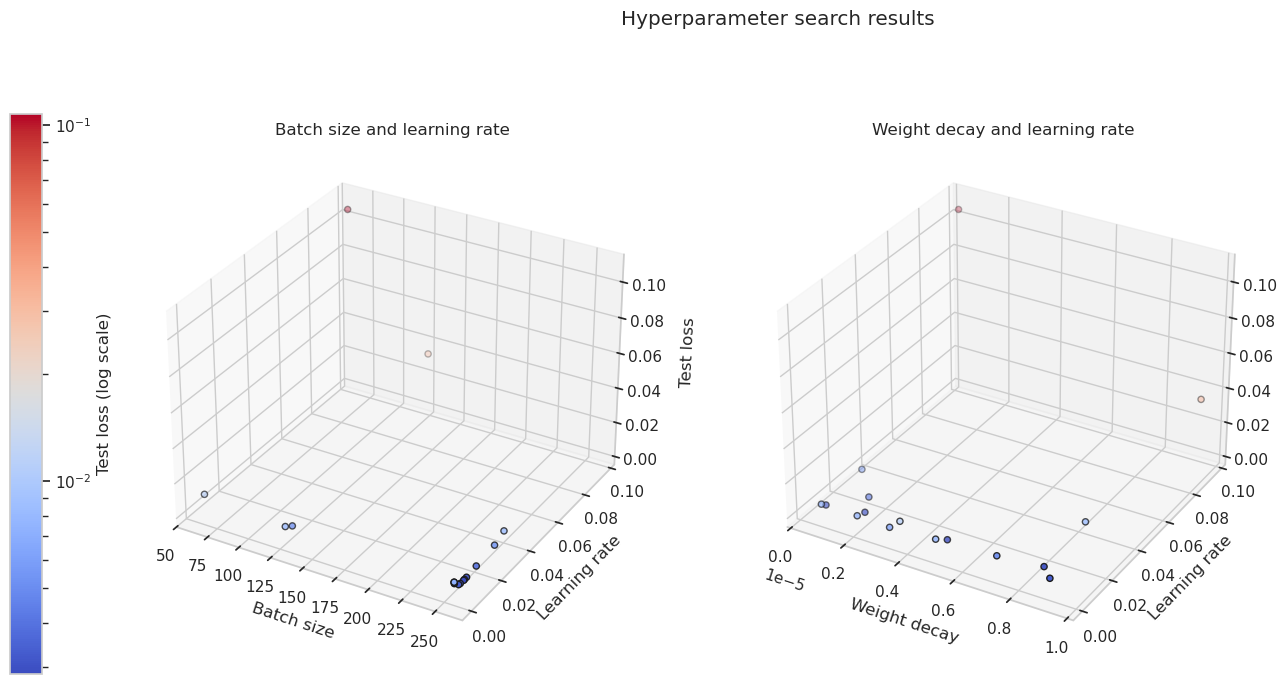

In [156]:
sns.set(style="whitegrid")

fig, axs = plt.subplots(1, 2, figsize=(16, 8), subplot_kw={"projection": "3d"})

# Normalize color scale across both plots
norm = LogNorm(
    vmin=metric_value.min(), vmax=metric_value.max()
)
cmap = plt.cm.coolwarm

# Left 3D scatter plot
sc1 = axs[0].scatter(
    tuner_loss["batch-size"],
    tuner_loss["learning-rate"],
    metric_value,
    c=metric_value,
    cmap=cmap,
    norm=norm,
    edgecolor="k"
)
axs[0].set_title("Batch size and learning rate")

# Right 3D scatter plot
sc2 = axs[1].scatter(
    tuner_loss["weight-decay"],
    tuner_loss["learning-rate"],
    metric_value,
    c=metric_value,
    cmap=cmap,
    norm=norm,
    edgecolor="k"
)
axs[1].set_title("Weight decay and learning rate")

axs[0].set_xlabel("Batch size")
axs[1].set_xlabel("Weight decay")
for ax in axs:
    ax.set_ylabel("Learning rate")
    ax.set_zlabel("Test loss", labelpad=10)

# Add a common color bar
cbar_ax = fig.add_axes([0.02, 0.15, 0.02, 0.7])  # Position color bar
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
cbar.set_label("Test loss (log scale)")

# Show plot
fig.suptitle("Hyperparameter search results")
fig.subplots_adjust(left=0.1, right=0.8)
plt.show()

In [165]:
tuner_loss["batch-size"].value_counts()

batch-size
256    11
128     3
64      2
Name: count, dtype: int64

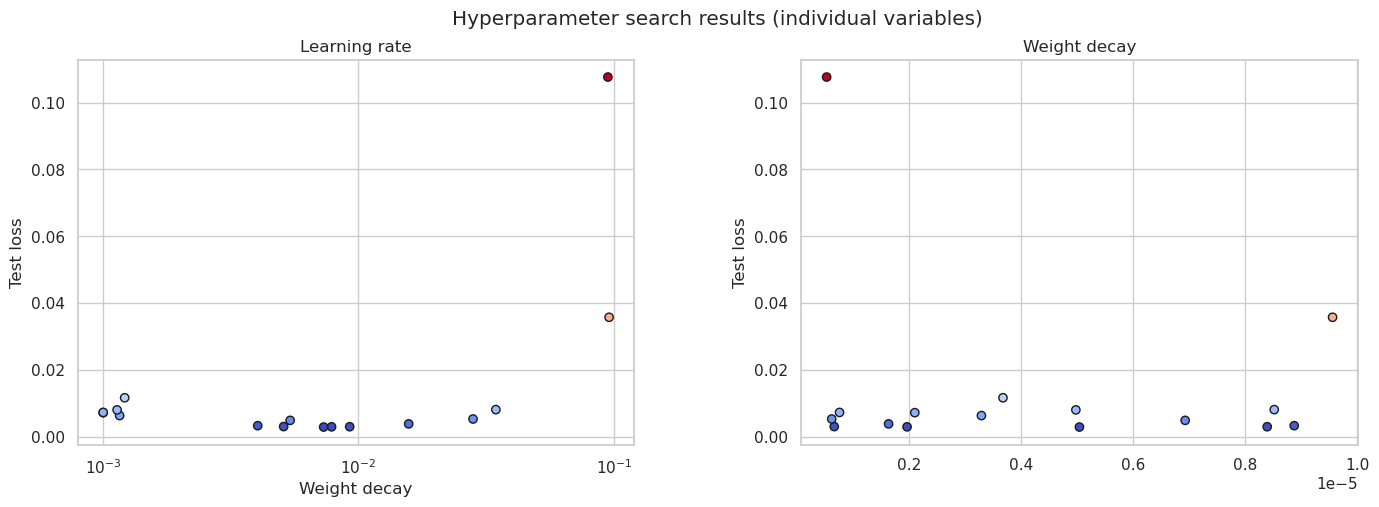

In [158]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

sc1 = axs[0].scatter(
    tuner_loss["learning-rate"],
    metric_value,
    c=metric_value,
    cmap=cmap,
    norm=norm,
    edgecolor="k"
)
axs[0].set_title("Learning rate")
axs[0].set_xlabel("Learning rate (log scale)")
axs[0].set_xscale("log")

sc2 = axs[1].scatter(
    tuner_loss["weight-decay"],
    metric_value,
    c=metric_value,
    cmap=cmap,
    norm=norm,
    edgecolor="k"
)
axs[1].set_title("Weight decay")
axs[0].set_xlabel("Weight decay")

for ax in axs:
    ax.set_ylabel("Test loss")

# Show plot
fig.suptitle("Hyperparameter search results (individual variables)")
fig.subplots_adjust(left=0.1, right=0.9, wspace=0.3)
plt.show()

## Model Profiling and Debugging

I create and finetune a new model using the best hyperparameters that were found during the hyperparameter tuning.

I use the `train_model.py` script to perform model profiling and debugging.

I base the debugging rules config on this [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-built-in-rules.html)

I evaulate the final model on the **test** set. I used the validation set to find the best set of hyperparameters.
Eveluating the final model on the separate **test** data will be the proxy of how well the model would behave on unseen data.

### Train a model using the best set of hyperparameters

In [5]:
rules = [
    Rule.sagemaker(
        base_config=rule_configs.vanishing_gradient(),
        rule_parameters={
            "threshold": "0.0000001"
        },
        collections_to_save=[
            CollectionConfig(
                name="gradients",
                parameters={
                    "save_interval": "5"
                }
            )
        ]
    ),
    Rule.sagemaker(
        base_config=rule_configs.loss_not_decreasing(),
        rule_parameters={
                "tensor_regex": ".*CrossEntropyLoss.*",
                "use_losses_collection": "True",
                "num_steps": "10",
                "diff_percent": "0.1",
                "increase_threshold_percent": "5",
                "mode": "GLOBAL"
        },
        collections_to_save=[
            CollectionConfig(
                name="losses",
                parameters={
                    "save_interval": "1"
                }
            )
        ]
    ),

    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "5",
        "eval.save_interval": "1"
    },
)

In [6]:
best_hyperparameters = {
    'batch-size': "256",
    'epochs': "5",
    'learning-rate': '0.007304133573457823',
    'weight-decay': '5.039936927695963e-06',
    "log-interval": "2",
}

In [9]:
estimator = PyTorch(
    entry_point="train_model.py",
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    framework_version="1.13",
    py_version="py39",
    hyperparameters=best_hyperparameters,
    rules=rules,
    debugger_hook_config=hook_config,
)

estimator.fit(
    {
        "training": TrainingInput("s3://sagemaker-us-east-1-007260079220/datasets/dogImages/train/", distribution="FullyReplicated"),
        "test": TrainingInput("s3://sagemaker-us-east-1-007260079220/datasets/dogImages/test/", distribution="FullyReplicated"),
    },
    wait=True
)

[04/16/25 12:39:09] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=412544;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=619028;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=684660;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=515277;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#681\681]8;;\
                             instance_type, framework etc.                                                         

[04/16/25 12:39:10] INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=306594;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=625763;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#681\681]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Creating training-job with name:                                       ]8;id=769761;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=896331;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#1042\1042]8;;\
                             pytorch-training-2025-04-16-12-39-09-837                                              

2025-04-16 12:39:14 Starting - Starting the training job...
2025-04-16 12:39:41 Starting - Preparing the instances for trainingVanishingGradient: InProgress
LossNotDecreasing: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
..
.....04-16 12:40:01 Downloading - Downloading input data.
..............41:10 Downloading - Downloading the training image.
.bash: cannot set terminal process group (-1): Inappropriate ioctl for device..
bash: no job control in this shell
/opt/conda/lib/python3.9/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/opt/conda/lib/python3.9/site-packages/paramiko/transport.py:259: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms

The accuracy of the final model on the test set is $82.54\%$. The accuracy of the best hyperparameter tuning job on the validation set was $84.19\%$:

![image.png](images/validation_accuracy.png)

### Plot the debugging output

In [10]:
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2025-04-16 12:56:34.643 default:142 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-007260079220/pytorch-training-2025-04-16-12-39-09-837/debug-output
[2025-04-16 12:56:35.069 default:142 WARNING s3handler.py:184] Encountered the exception [SYS] unknown error (_ssl.c:2580) while reading s3://sagemaker-us-east-1-007260079220/pytorch-training-2025-04-16-12-39-09-837/debug-output/index/000000000/000000000020_worker_0.json . Will retry now


In [11]:
trial.tensor_names()

[2025-04-16 12:56:39.402 default:142 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2025-04-16 12:56:40.420 default:142 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight']

In [13]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


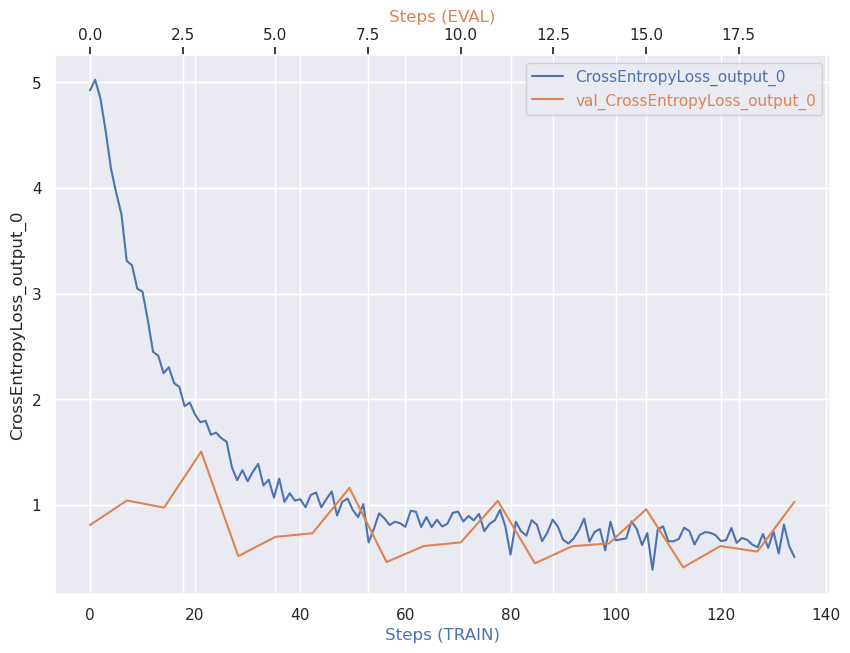

In [14]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

In [15]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [16]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-007260079220/pytorch-training-2025-04-16-12-39-09-837/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-007260079220/pytorch-training-2025-04-16-12-39-09-837/rule-output/ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json to ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json
download: s3://sagemaker-us-east-1-007260079220/pytorch-training-2025-04-16-12-39-09-837/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-007260079220/pytorch-training-2025-04-16-12-39-09-837/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-007260079220/pytorch-training-2025-04-16-

In [18]:
# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [19]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

In [ ]:
**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

## Model Deploying

In [31]:
estimator

In [32]:
estimator.deploy?

Signature:
estimator.deploy(
    initial_instance_count=None,
    instance_type=None,
    serializer=None,
    deserializer=None,
    accelerator_type=None,
    endpoint_name=None,
    use_compiled_model=False,
    wait=True,
    model_name=None,
    kms_key=None,
    data_capture_config=None,
    tags: Union[List[Dict[str, Union[str, sagemaker.workflow.entities.PipelineVariable]]], Dict[str, Union[str, sagemaker.workflow.entities.PipelineVariable]], NoneType] = None,
    serverless_inference_config=None,
    async_inference_config=None,
    volume_size=None,
    model_data_download_timeout=None,
    container_startup_health_check_timeout=None,
    inference_recommendation_id=None,
    explainer_config=None,
    **kwargs,
)
Docstring:
Deploy the trained model to an Amazon SageMaker endpoint.

 And then return ``sagemaker.Predictor`` object.

More information:
http://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-training.html

Args:
    initial_instance_count (int): The initial n

In [20]:
predictor=estimator.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.xlarge"
)

[04/16/25 13:06:21] INFO     Repacking model artifact                                                  ]8;id=230411;file:///opt/conda/lib/python3.11/site-packages/sagemaker/model.py\model.py]8;;\:]8;id=340323;file:///opt/conda/lib/python3.11/site-packages/sagemaker/model.py#819\819]8;;\
                             (s3://sagemaker-us-east-1-007260079220/pytorch-training-2025-04-16-12-39-             
                             09-837/output/model.tar.gz), script artifact                                          
                             (s3://sagemaker-us-east-1-007260079220/pytorch-training-2025-04-16-12-39-             
                             09-837/source/sourcedir.tar.gz), and dependencies ([]) into single tar.gz             
                             file located at                                                                       
                             s3://sagemaker-us-east-1-007260079220/pytorch-training-2025-04-16-13-06-2             
                             1-152/model.tar.gz. This may take some time depending on model size...                

[04/16/25 13:06:29] INFO     Creating model with name: pytorch-training-2025-04-16-13-06-21-152     ]8;id=274743;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=714805;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4094\4094]8;;\

                    INFO     Creating endpoint-config with name                                     ]8;id=542117;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=42835;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#5889\5889]8;;\
                             pytorch-training-2025-04-16-13-06-21-152                                              

[04/16/25 13:06:30] INFO     Creating endpoint with name pytorch-training-2025-04-16-13-06-21-152   ]8;id=354174;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=479901;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4711\4711]8;;\

------!

In [21]:
print(f"The deployed endpoint name is: {predictor.endpoint_name}")

The deployed endpoint name is: pytorch-training-2025-04-16-13-06-21-152


I test the endpoint on one of Cavalier images from the test set:

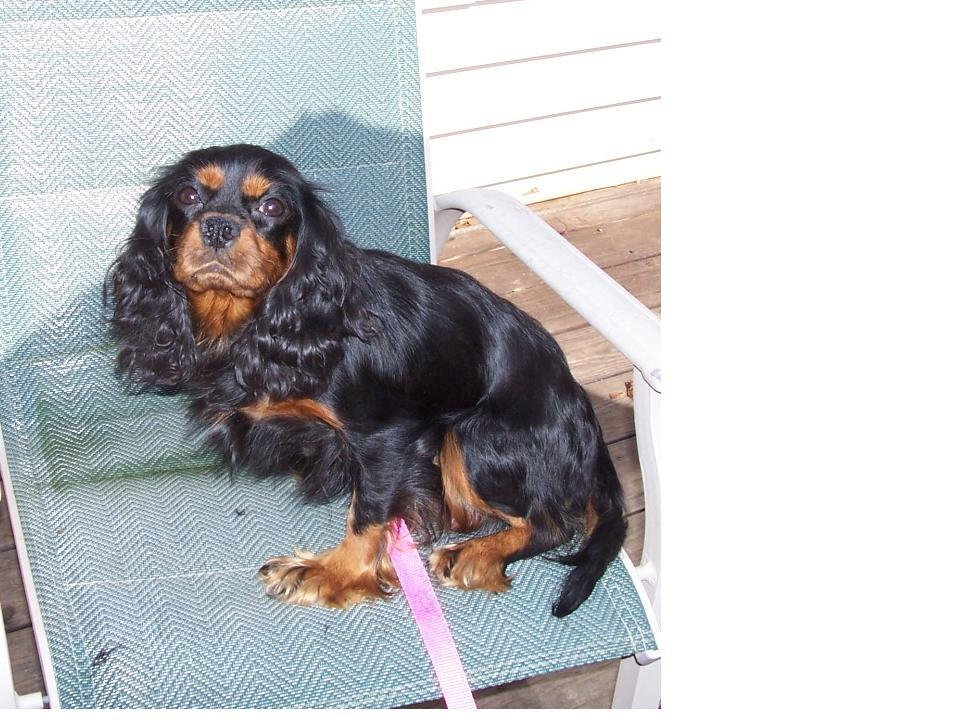

In [25]:
image_path = "./dogImages/test/046.Cavalier_king_charles_spaniel/Cavalier_king_charles_spaniel_03294.jpg"
image = Image.open(image_path)
display(image)

In [27]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
preprocessed_image = transform(image).unsqueeze(0)
preprocessed_image = preprocessed_image.to("cpu")

In [29]:
response = predictor.predict(image)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 response = predictor.predict(image)                                                          │
│   2                                                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/base_predictor.py:212 in predict               │
│                                                                                                  │
│   209 │   │   if inference_component_name:                                                       │
│   210 │   │   │   request_args["InferenceComponentName"] = inference_component_name              │
│   211 │   │                                                                                      │
│ ❱ 212 │   │   response = self.sagemaker_session.sagemaker_runtime_client.invoke_endpoint(**req   │
│   213 │   │   return self._handle_response(response)                                             │
│   214 │                                                                                          │
│   215 │   def _handle_response(self, response):                                                  │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/botocore/client.py:569 in _api_call                      │
│                                                                                                  │
│    566 │   │   │   │   │   f"{py_operation_name}() only accepts keyword arguments."              │
│    567 │   │   │   │   )                                                                         │
│    568 │   │   │   # The "self" in this scope is referring to the BaseClient.                    │
│ ❱  569 │   │   │   return self._make_api_call(operation_name, kwargs)                            │
│    570 │   │                                                                                     │
│    571 │   │   _api_call.__name__ = str(py_operation_name)                                       │
│    572                                                                                           │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/botocore/client.py:1023 in _make_api_call                │
│                                                                                                  │
│   1020 │   │   │   │   "Code"                                                                    │
│   1021 │   │   │   )                                                                             │
│   1022 │   │   │   error_class = self.exceptions.from_code(error_code)                           │
│ ❱ 1023 │   │   │   raise error_class(parsed_response, operation_name)                            │
│   1024 │   │   else:                                                                             │
│   1025 │   │   │   return parsed_response                                                        │
│   1026                                                                                           │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (0) 
from primary with message "Your invocation timed out while waiting for a response from container primary. Review 
the latency metrics for each container in Amazon CloudWatch, resolve the issue, and try again.". See 
https://us-east-1.console.aws.amazo

In [30]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

[04/16/25 15:07:01] INFO     Deleting endpoint configuration with name:                             ]8;id=513444;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=128982;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4865\4865]8;;\
                             pytorch-training-2025-04-16-13-06-21-152                                              

                    INFO     Deleting endpoint with name: pytorch-training-2025-04-16-13-06-21-152  ]8;id=336926;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=474448;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4855\4855]8;;\